# A simple Product Recommendation process basd on product descriptions

### Goal of the project

Given an amazon product description, I'm trying to see how what products will be 'recommended'. For example, if I'm purchasing a Banana Republic t-shirt, I want to see if the recommendation system just recommends other t-shirts or/and other Banana Republic products. For simplicity, I'll first visually inspect the results and then analyze results based on the descriptions.  The original metadata file had information on more than 1.5 million products. This json file has products from the "Clothing, Shoes and Jewelry" category. For this exercise, I'm using information from just 40000 products. 

### Motivation for this project

Any decent practical product recommender system will have been trained using a state-of-the-art deep learning architecture and with data from millios of products. What's more? Products evolve over time. Companies do away woth old products and try to promote new ones. This means they'll probably have to reinvent the wheel every now and then. They would have to obtain new reliable data, preprocess it and then train the model and evalute it's performance. 

But in this exercise, I'll try to obtain practical recommendations for products with absolutly no training at all. Sounds too good to be true? You're probably wondering where/how the magic happens. All I'm doing is transforming the descriptions of products using tf-idf vectorizer followed by computing their relative closeness (This step doesn't involve any modeling/using a complex deep learning architecture). Also,the time taken to compute the cosine similarities matrix was negligible.

But enough talk now. Let's get to business and see how this could work like a practical recommendation system!!!

### Practical application

Now, would something like be practical for a large e-commerce company like Amazon? Probably not! They have the resources and architecture to make sure that their recommender system(s) don't go out of date. They wouldn't have a problem gathering data from millions of products. After all, it's not practical to compute the cosine similarities of tens of millions of products each day!

So how could something like this be used? Small scale e-commerce/retail companies probably don't have millions of products. They may have a few 1000 / 100k products. That's certainly not enough data to train a state of the art model. Even if they are able to obtain enough data and come up with a well functioning model, they may not have the time and resources to keep updating the model to adjust to a rapidly changing market. But they could still come up with a neat recommender system if they have their product information in a file or a database. Their tradeoff would be the computation of the similarities matrix every time a product is outdated or a new one is added. For tens of thousands of images, the time taken to compute the similarities matrix is negligible. PS: It took me just around 3 minutes to compute the cosine similarities mareix for over 40000 product descriptions.

<font color='maroon'>

### Outline of the entire process:

1) Read the preprocessed amazon products file.

2) Transform the descriptions in the file using tf-idf vectorization by ignoring all stop words.

3) Transform the tf-idf vector to a numpy array.

4) Compute the relative cosine similarities matrix for all the product descriptions.

5) Given a product, I'll try to find the nine closest products. This will be determined by the magnitude of the computed  relative cosine similarities.

6) Using the 'imUrl' field in the preprocessed metadata file, we'll plot each of the 9 relatd products that are recommended.
</font>

In [1]:
import pandas as pd
import json
import ast
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
import requests

### STEP 1

In [2]:
new_df = pd.read_csv('clean_data.csv')

In [3]:
#Inspecting the structure of the file
new_df.head()

Unnamed: 0    imdb_id               original_title  \
0           0  tt0114709                    Toy Story   
1           1  tt0113497                      Jumanji   
2           2  tt0113228             Grumpier Old Men   
3           3  tt0114885            Waiting to Exhale   
4           4  tt0113041  Father of the Bride Part II   

                     genres                                      modified_desc  
0   Animation,Comedy,Family  led woody andy's toys live happily room andy's...  
1  Adventure,Fantasy,Family  siblings judy peter discover enchanted board g...  
2            Romance,Comedy  family wedding reignites ancient feud next-doo...  
3      Comedy,Drama,Romance  cheated mistreated stepped women holding breat...  
4                    Comedy  george banks recovered daughter's wedding rece...

In [4]:
len(new_df)

27412

We will now only choose the fields of interest

In [5]:
new_df = new_df.drop('Unnamed: 0', axis =1)

Dropping rows with NaN values

In [6]:
new_df = new_df.drop_duplicates()

In [7]:
new_df = new_df.dropna()

In [8]:
len(new_df)

25750

In [9]:
new_df = new_df.reset_index(drop = True)

In [10]:
new_df.head()

imdb_id               original_title                    genres  \
0  tt0114709                    Toy Story   Animation,Comedy,Family   
1  tt0113497                      Jumanji  Adventure,Fantasy,Family   
2  tt0113228             Grumpier Old Men            Romance,Comedy   
3  tt0114885            Waiting to Exhale      Comedy,Drama,Romance   
4  tt0113041  Father of the Bride Part II                    Comedy   

                                       modified_desc  
0  led woody andy's toys live happily room andy's...  
1  siblings judy peter discover enchanted board g...  
2  family wedding reignites ancient feud next-doo...  
3  cheated mistreated stepped women holding breat...  
4  george banks recovered daughter's wedding rece...

The index will be reset by ignoring the old indices.

### STEP 2

Now, the 'description' column will be transformed using the TF-IDF vectorizer and english stop words. (Common non-descriptive/non-adjective words 'a', 'and' and 'the' will be ignored. 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=2, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(new_df.modified_desc)

### STEP 3

In [12]:
Xtfidf = Xtfidf.toarray()

In [13]:
Xtfidf.shape

(25750, 26243)

In [14]:
Xtfidf[0]

array([0., 0., 0., ..., 0., 0., 0.])

### STEP 4

In this step, the relative cosine similarities matrix will be computed. For two duplicate images, the computed cosine similarity is 1. If the images are vastly different from one another, the similarity coefficient will be close to 0. Now, the cosine similarity matrix for just the first three images.

In [15]:
cos_matrix = cosine_similarity(Xtfidf[:3])

In [16]:
cos_matrix

array([[1.        , 0.0157186 , 0.        ],
       [0.0157186 , 1.        , 0.04806064],
       [0.        , 0.04806064, 1.        ]])

As expected, when a product correlation is computed with itself, 1 is the computed similarity. The first and third products are correlated too. But the magnitude is just ~0.02 which could indicate that they are entirely different products.

Since the relative similarity is computed for each element in the dataset, a square matrix is obtained.

Next, we'll compute the cosine similarities of all the products in our dataset.

In [17]:
words_siilar = cosine_similarity(Xtfidf)

In [18]:
words_siilar.shape

(25750, 25750)

We get a square matrix of size 40333x40333.

In the next cell bock, a simple function has been defined to help retrieve the image url and display the product image.

In [27]:
KEY = 'a997c6a74e5b2d33c1e329b556a1769d'

In [21]:
def get_images(imdb_id):
    IMG_PATTERN = 'http://api.themoviedb.org/3/movie/{imdbid}/images?api_key={key}' # The URL pattern for the movie posters. With the key and IMDB ID, the generated URL can be used to download the posters.
    r = requests.get(IMG_PATTERN.format(key=KEY,imdbid=imdb_id)) # KEY is the API key and i[0] identifies the unique IMDB ID.
    api_response = r.json() # The generated response is converted to json.
    
    try:                    # Some of the movies do not contain any information and much less, any posters. Hence, exception handling will be used to avoid errors during runtime
        
        posters = api_response['posters'] # Contains information about the movie posters to be downloaded.
    except KeyError:
        pass
       # print('error for ' + imdb_id)
                  # 'continue' can only be used in a loop. This command moves on the next row if no vible information is found.
    
    base_url = 'http://image.tmdb.org/t/p/'  # The base url for the TMDB API
    max_size = 'w342'                        # Movie sizes are available in different sizes: w342, w500, and orignal. w342 images are smaller than w500 and 'original' images.
    try:                                     # Some movies do not have posters and hence, exception handling will be used to avoid runtime errors
       
        rel_path = posters[0]['file_path']   # Some movies have multiple posters. A few movies have up to 9 posters or so. What's even more bothersome is that some of them are duplicates. Hence, onlyone image per movie will be used.
    except IndexError:
        pass
    url = "{0}{1}{2}".format(base_url, max_size, rel_path) # If the movie does have a poster, this step generated the movie poster url
    #print(url)
    
    try:                                                          #Exception handling will be used since some of the URLs will not open or throw an error.
        resp = urllib.request.urlopen(url)                        # This step read the image from the url
        image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
        #new_img = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
        new_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except urllib.error.URLError as e:
        print(e.reason)
    return new_img

In [28]:
jumanji_poster = get_images('tt0113497')

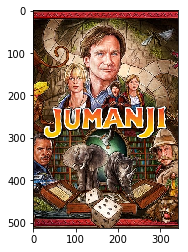

In [29]:
plt.imshow(jumanji_poster )

In [23]:
def get_related_movies(imdbid, data = new_df):
    j = 4 #This variable will be used in the subplots for positioning of the related product items
    movie = data.loc[data.imdb_id == imdbid].index
    index_list = []
    for k in movie:
        index_list.append(k)
    index_num = index_list[0]
    similar_prod_arr = words_siilar[index_num].argsort()[::-1][:13] # Computes the 9 closes product descriptions based on cosin similarity matrix.
    #print(similar_prod_arr)
    prod_img = get_images(imdbid) # Retrieving the image from the URL
    fig, ax = plt.subplots(figsize=(19,16))
    plt.subplot(5,3,2)
    plt.imshow(prod_img) # Plotting the product image
    plt.title('Product Image',fontsize=14, fontweight='bold')
    for i in similar_prod_arr[1:]:
        img = get_images(data['imdb_id'].loc[i]) # Retrieves the images of all items related to the product
        plt.subplot(5,3,j) 
        plt.imshow(img) # Plots the images
        plt.xlabel('Related movie ID: ' + str(i))
        j+=1

### STEP 6

Let's get started with the fun part already!

Before we begin seeing results right away, let us inspect th product in query.

In [31]:
new_df.loc[new_df.imdb_id == 'tt0418279']

imdb_id original_title                            genres  \
8816  tt0418279   Transformers  Adventure,Science,Fiction,Action   

                                          modified_desc  
8816  young teenager sam witwicky becomes involved a...

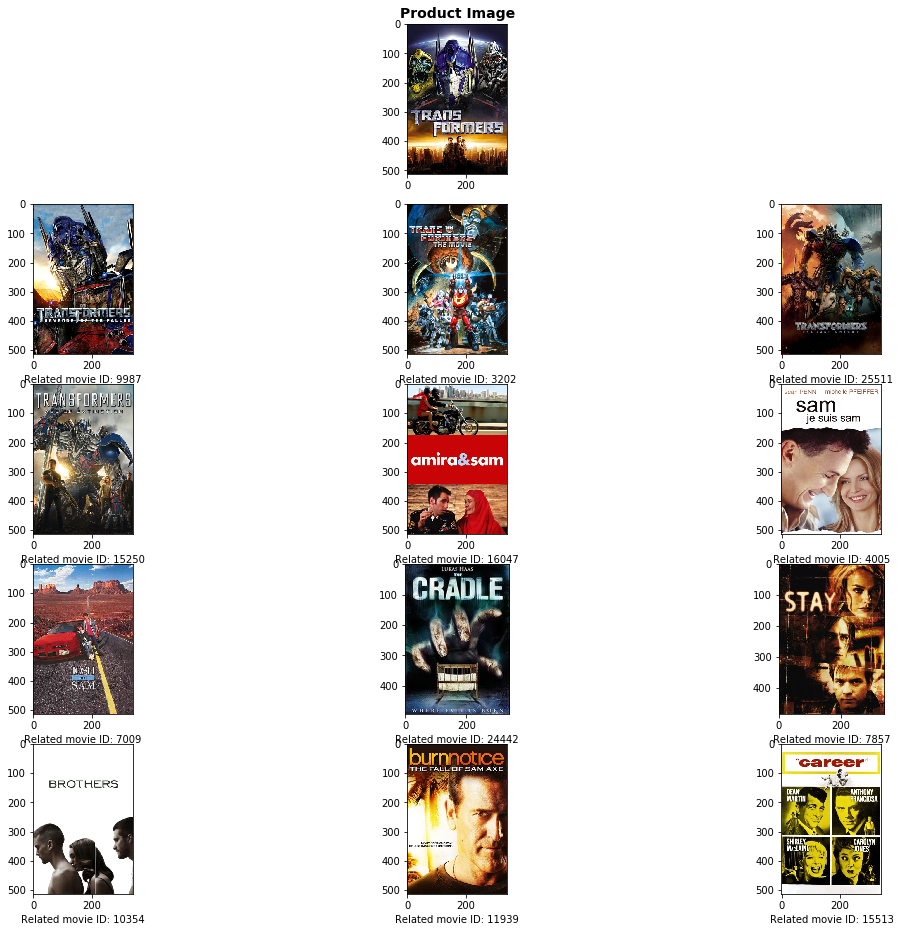

In [30]:
get_related_movies('tt0418279')

In [32]:
new_df['genres'].loc[[16047, 4005, 7009, 24442, 7857, 10354, 11939, 15513]]

16047                   Drama,Romance,Comedy
4005                                   Drama
7009                 Adventure,Action,Comedy
24442                        Horror,Thriller
7857                  Mystery,Thriller,Drama
10354                     Drama,Thriller,War
11939    Comedy,Crime,Drama,Mystery,Thriller
15513                                  Drama
Name: genres, dtype: object

In [34]:
new_df.loc[new_df.imdb_id == 'tt2115386']

imdb_id                        original_title  \
24979  tt2115386  Scrat's Continental Crack-Up: Part 2   

                           genres  \
24979  Animation,Comedy,Adventure   

                                           modified_desc  
24979  short film continues adventures title characte...

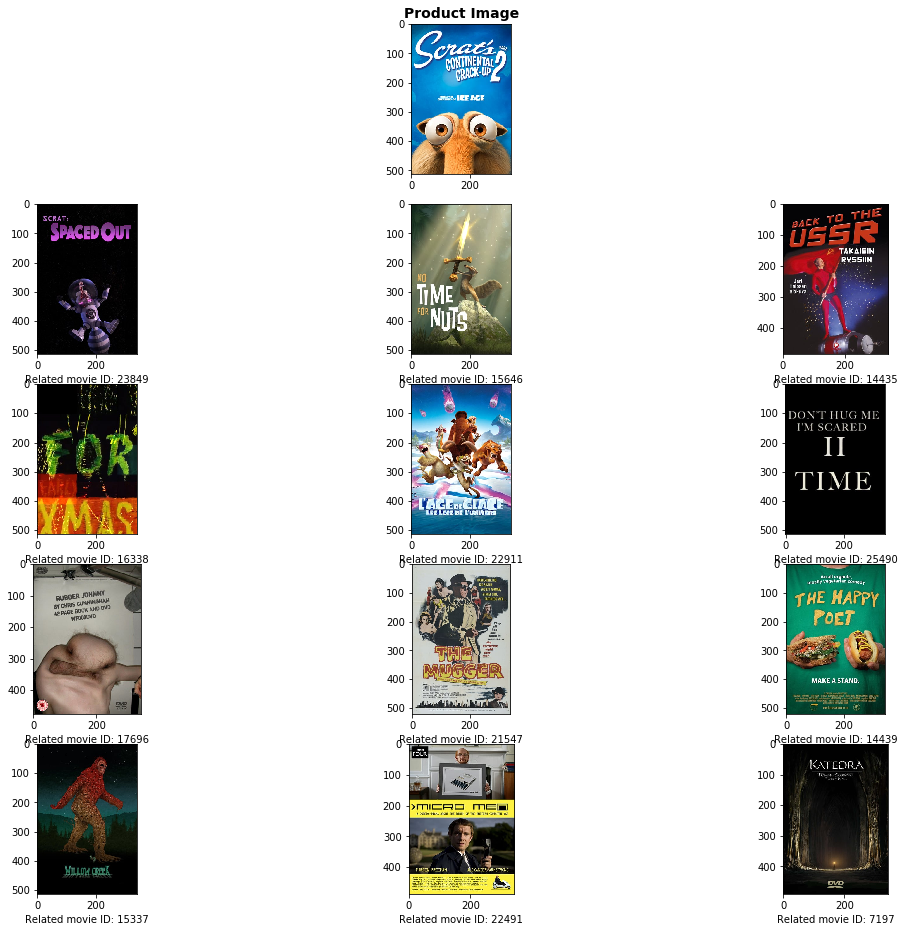

In [33]:
get_related_movies('tt2115386')

In [35]:
new_df['genres'].loc[[23849, 15646, 14435, 16338, 25490, 17696, 21547, 14439, 15337, 22491, 7197]]

23849     Science,Fiction,Comedy,Animation
15646           Adventure,Animation,Family
14435                         Drama,Comedy
16338                            Animation
25490                               Horror
17696                     Animation,Horror
21547                       Drama,Thriller
14439                               Comedy
15337    Adventure,Horror,Mystery,Thriller
22491                                Drama
7197             Science,Fiction,Animation
Name: genres, dtype: object

In [36]:
new_df.loc[new_df.imdb_id == 'tt2345759']

imdb_id original_title                     genres  \
24797  tt2345759      The Mummy  Thriller,Action,Adventure   

                                           modified_desc  
24797  though safely entombed crypt deep beneath unfo...

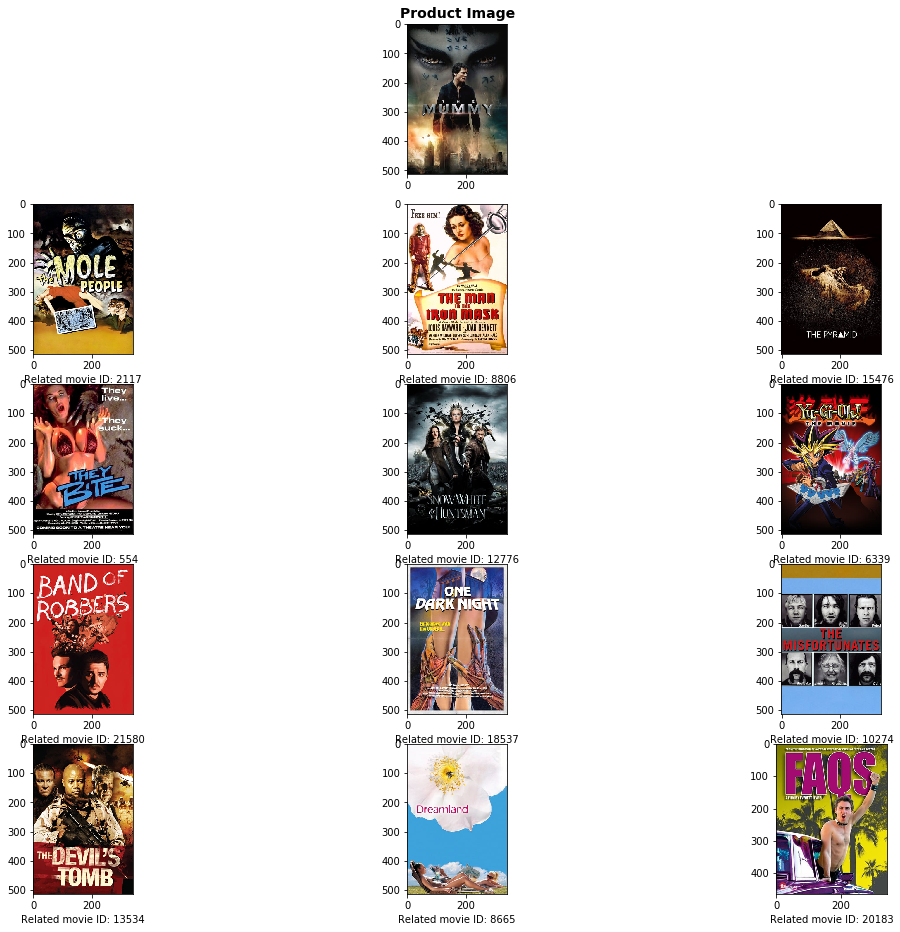

In [37]:
get_related_movies('tt2345759')

In [38]:
new_df.genres.loc[[2117, 8806, 554, 12776, 6339, 21580, 18537, 10274, 13534, 8665, 20183]]

2117              Adventure,Fantasy,Horror,Science,Fiction
8806                                         Romance,Drama
554                          Comedy,Horror,Science,Fiction
12776                              Adventure,Fantasy,Drama
6339     Adventure,Fantasy,Animation,Action,Comedy,Thri...
21580                      Adventure,Comedy,Crime,Thriller
18537                                               Horror
10274                                         Drama,Comedy
13534               Action,Horror,Thriller,Science,Fiction
8665                         Drama,Romance,Science,Fiction
20183                                                Drama
Name: genres, dtype: object

In [39]:
new_df.loc[new_df.imdb_id == 'tt0429493']

imdb_id original_title                                  genres  \
10841  tt0429493     The A-Team  Thriller,Action,Adventure,Comedy,Crime   

                                           modified_desc  
10841  group iraq war veterans goes run us military f...

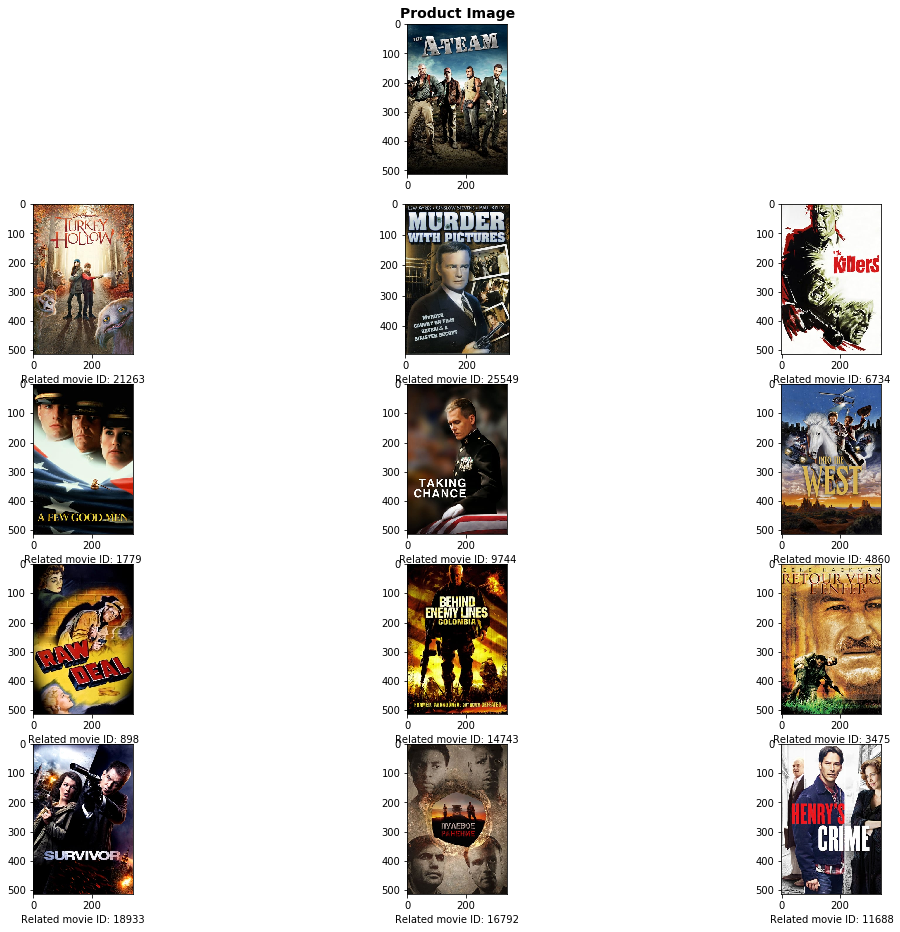

In [41]:
get_related_movies('tt0429493')

In [42]:
new_df.loc[new_df.imdb_id == 'tt1375666']

imdb_id original_title  \
10916  tt1375666      Inception   

                                                  genres  \
10916  Action,Thriller,Science,Fiction,Mystery,Adventure   

                                           modified_desc  
10916  cobb skilled thief commits corporate espionage...

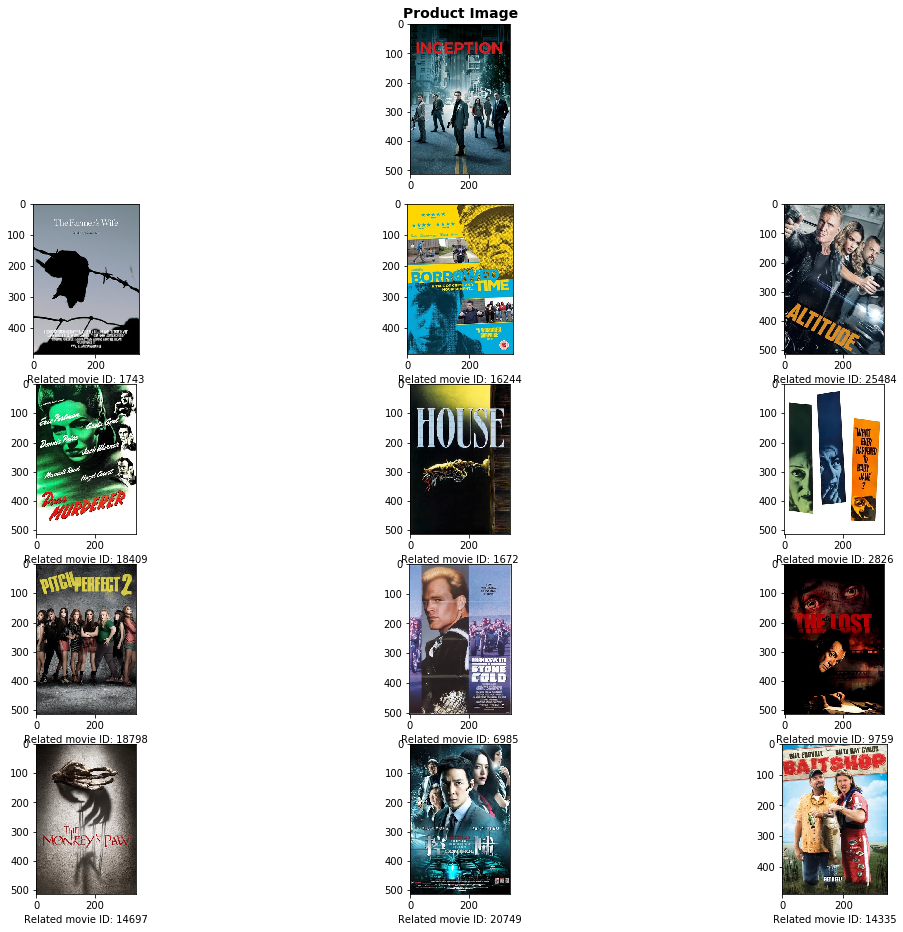

In [43]:
get_related_movies('tt1375666')

In [45]:
new_df['genres'].loc[[1743, 16244, 18409, 1672, 2826, 18798, 2985, 9759, 14697, 20749, 14335]]

1743                     Drama
16244                    Drama
18409                 Thriller
1672             Comedy,Horror
2826     Drama,Horror,Thriller
18798             Comedy,Music
2985               Crime,Drama
9759                  Thriller
14697          Horror,Thriller
20749                 Thriller
14335                   Comedy
Name: genres, dtype: object

In [46]:
new_df.loc[new_df.imdb_id == 'tt0838283']

imdb_id original_title  genres  \
9393  tt0838283  Step Brothers  Comedy   

                                          modified_desc  
9393  brennan huff dale doback might grown men stop ...

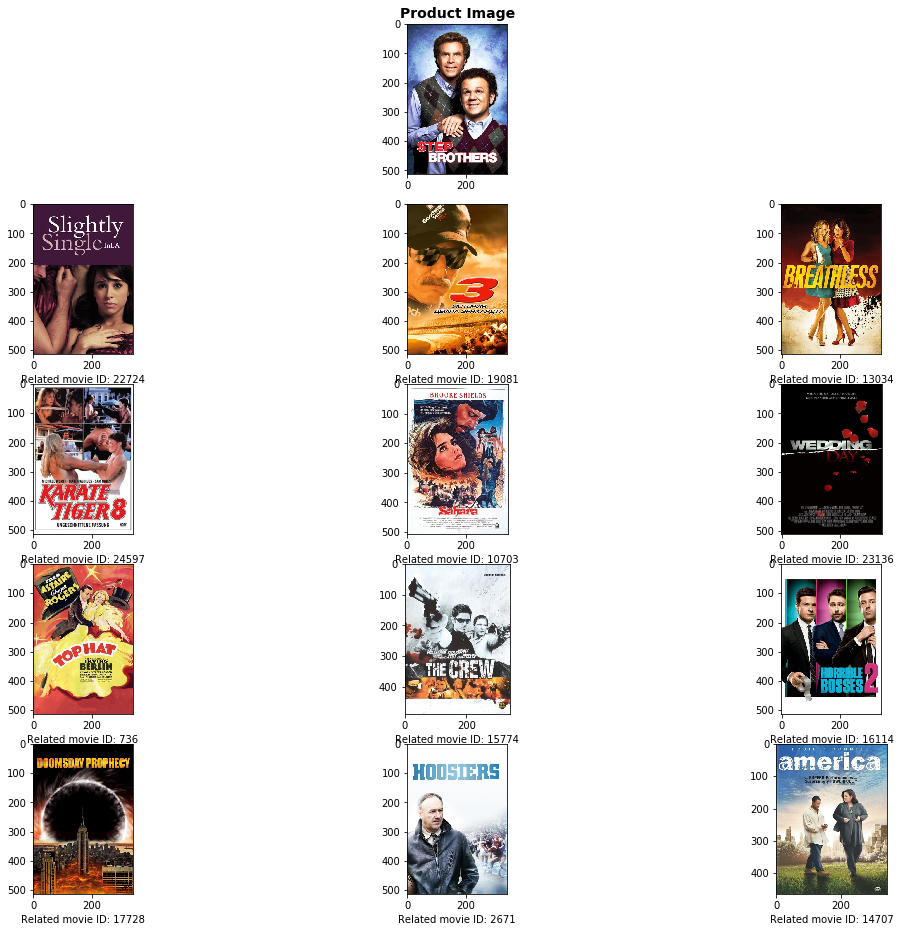

In [47]:
get_related_movies('tt0838283')

In [50]:
new_df['genres'].loc[[22724, 19081, 13034, 24597, 10703, 23136, 736, 15774, 16114, 17728, 2671, 14707]]

22724                     Comedy,Romance
19081                     TV,Movie,Drama
13034                    Comedy,Thriller
24597                             Action
10703     Action,Adventure,Drama,Romance
23136                              Drama
736                 Comedy,Music,Romance
15774        Drama,Action,Thriller,Crime
16114                             Comedy
17728    Action,Thriller,Science,Fiction
2671                        Drama,Family
14707                              Drama
Name: genres, dtype: object

In [52]:
new_df.loc[new_df.imdb_id == 'tt3896198']

imdb_id                  original_title  \
17043  tt3896198  Guardians of the Galaxy Vol. 2   

                                        genres  \
17043  Action,Adventure,Comedy,Science,Fiction   

                                           modified_desc  
17043  guardians must fight keep newfound family toge...

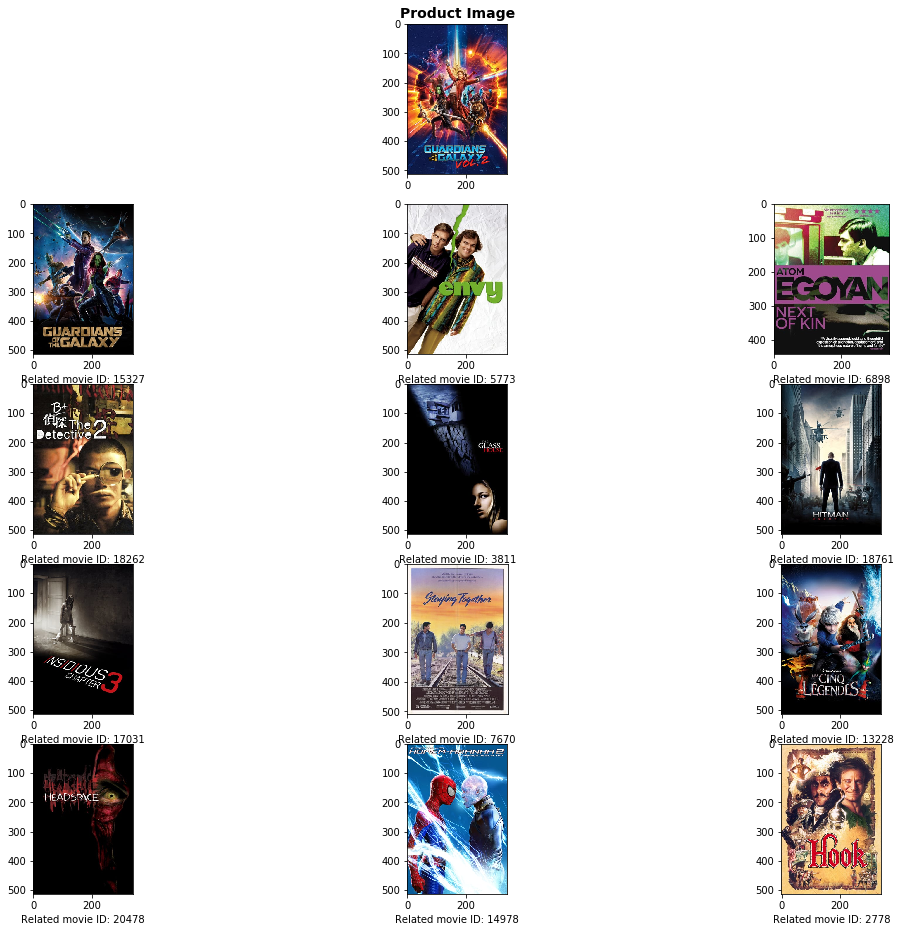

In [51]:
get_related_movies('tt3896198')

In [54]:
new_df.loc[new_df.imdb_id == 'tt0102926']

imdb_id            original_title                genres  \
502  tt0102926  The Silence of the Lambs  Crime,Drama,Thriller   

                                         modified_desc  
502  fbi trainee clarice starling ventures maximum-...

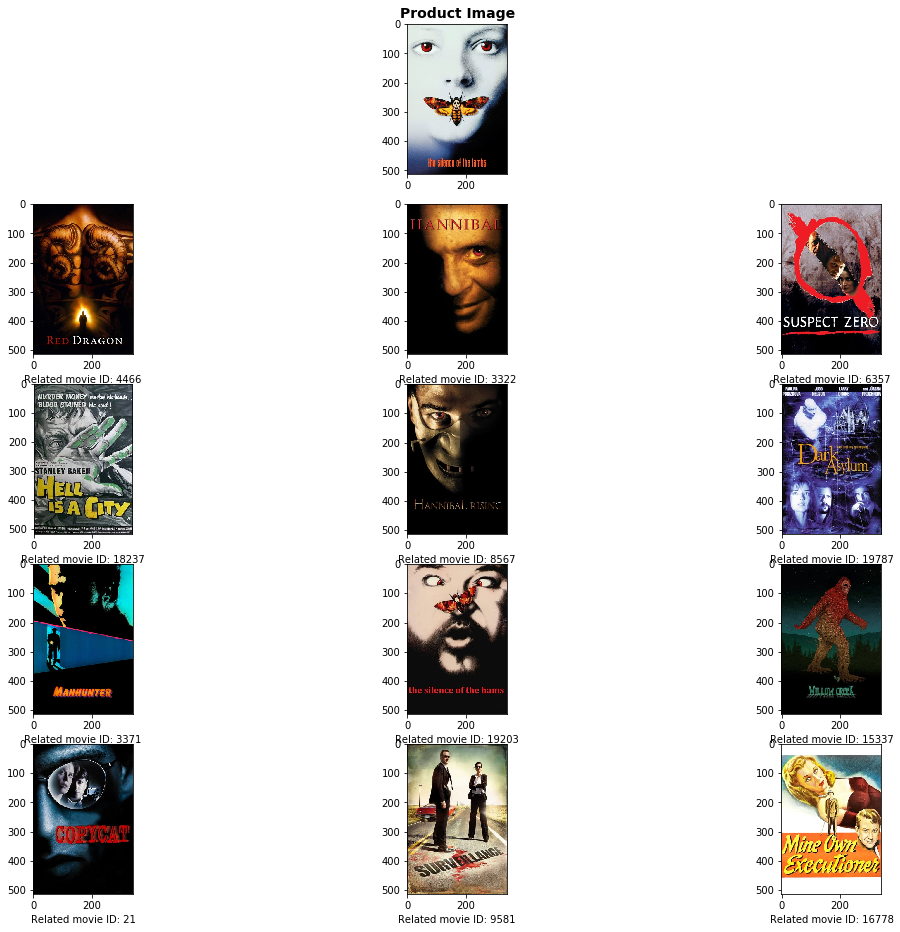

In [53]:
get_related_movies('tt0102926')

In [55]:
new_df['genres'].loc[[4466, 3322, 6357, 18237, 19787, 3371, 19203, 15337, 21, 1581, 16778]]

4466                 Crime,Thriller,Horror
3322           Crime,Drama,Thriller,Horror
6357                        Crime,Thriller
18237                       Crime,Thriller
19787                      Thriller,Horror
3371                 Crime,Horror,Thriller
19203                      Thriller,Comedy
15337    Adventure,Horror,Mystery,Thriller
21                          Drama,Thriller
1581             Comedy,Drama,Family,Music
16778                       Thriller,Drama
Name: genres, dtype: object

In [57]:
new_df.loc[new_df.imdb_id == 'tt0040498']

imdb_id    original_title          genres  \
25668  tt0040498  Julia Misbehaves  Comedy,Romance   

                                           modified_desc  
25668  julia william married soon separated snobbish ...

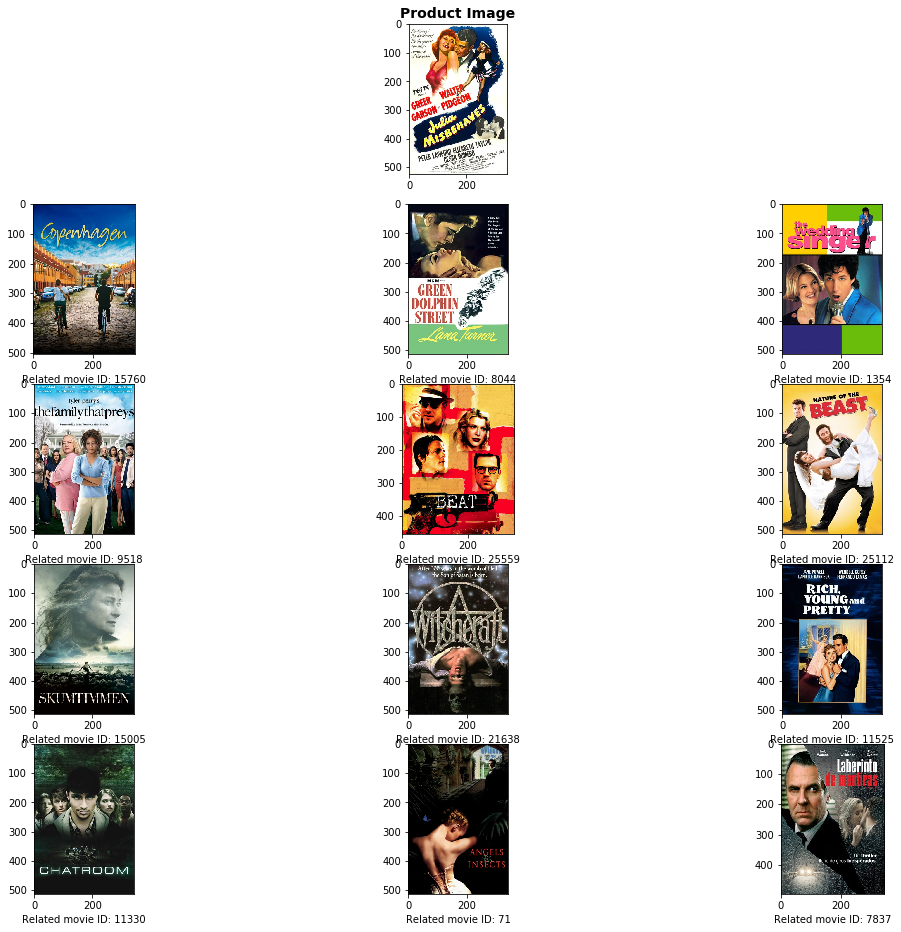

In [56]:
get_related_movies('tt0040498')

In [58]:
new_df['genres'].loc[[15760, 8044, 1354, 9518, 25559, 25112, 15005, 21638, 11525, 11330, 71, 7837]]

15760           Adventure,Romance,Drama
8044            Drama,Adventure,Romance
1354                     Romance,Comedy
9518                      Drama,Romance
25559                             Drama
25112    Comedy,Horror,Romance,Thriller
15005                     Drama,Mystery
21638                            Horror
11525              Music,Comedy,Romance
11330                    Drama,Thriller
71                        Drama,Romance
7837             Romance,Drama,Thriller
Name: genres, dtype: object

In [61]:
new_df.loc[new_df.imdb_id == 'tt0770828']

imdb_id original_title                                    genres  \
13859  tt0770828   Man of Steel  Action,Adventure,Fantasy,Science,Fiction   

                                           modified_desc  
13859  young boy learns extraordinary powers earth yo...

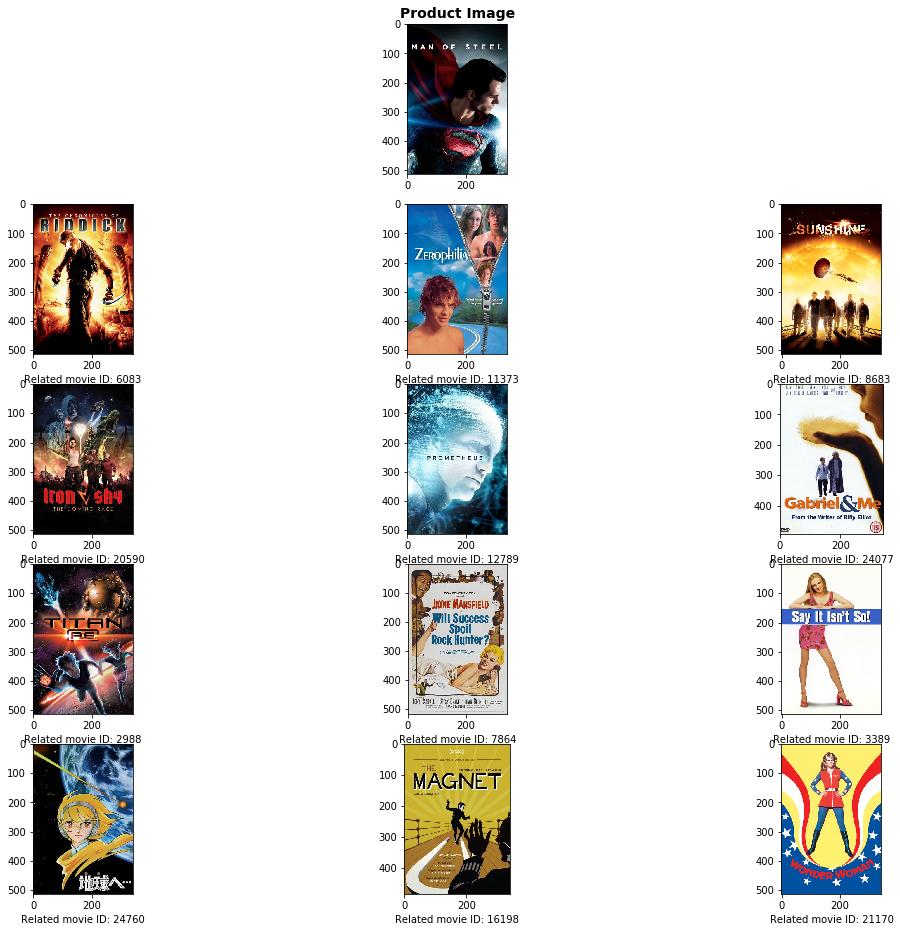

In [60]:
get_related_movies('tt0770828')

In [62]:
new_df['genres'].loc[[11373, 8683, 20590, 12789, 24077, 2988, 7864, 3389, 24760, 16198, 21170]]

11373                                       Comedy,Romance
8683                              Science,Fiction,Thriller
20590                Action,Comedy,Fantasy,Science,Fiction
12789                    Science,Fiction,Adventure,Mystery
24077                                                Drama
2988     Animation,Action,Science,Fiction,Family,Adventure
7864                                  Comedy,Drama,Romance
3389                                        Comedy,Romance
24760           Animation,Adventure,Action,Science,Fiction
16198                                               Comedy
21170                    Action,Adventure,Fantasy,TV,Movie
Name: genres, dtype: object

In [64]:
new_df.loc[new_df.imdb_id == 'tt1454468']

imdb_id original_title                          genres  \
14155  tt1454468        Gravity  Science,Fiction,Thriller,Drama   

                                           modified_desc  
14155  dr ryan stone brilliant medical engineer first...

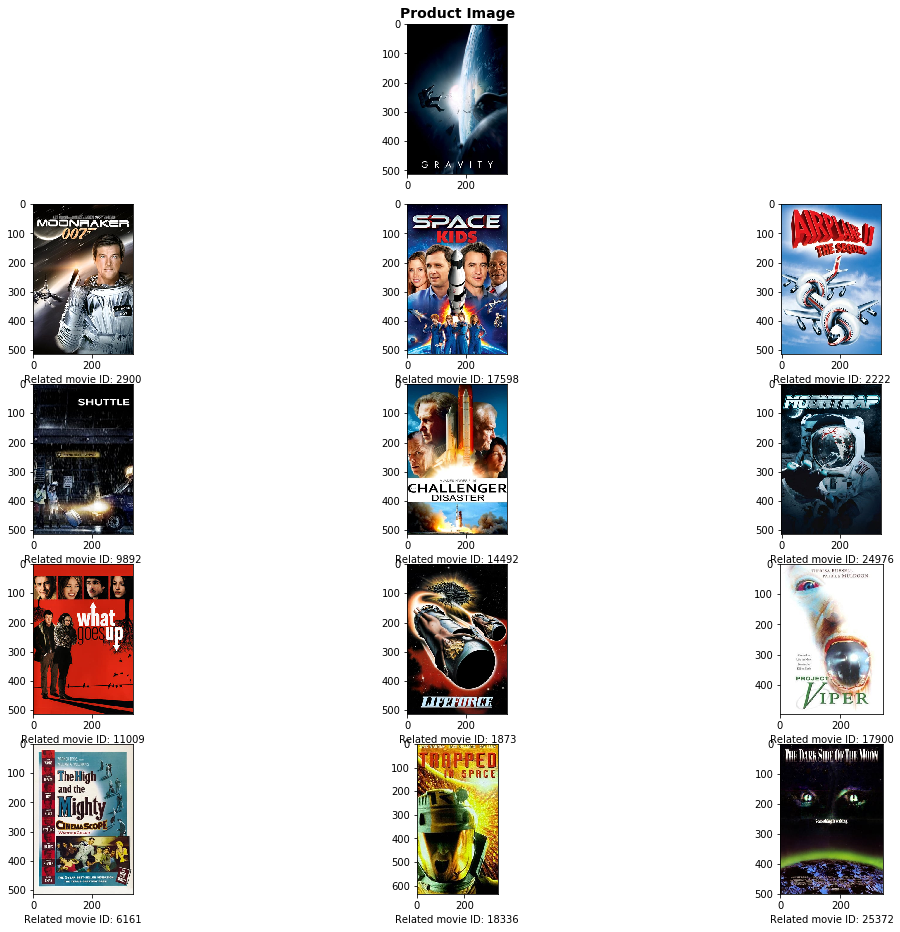

In [63]:
get_related_movies('tt1454468')

In [65]:
new_df['genres'].loc[[17598, 2222, 9892, 14492, 11009, 1873, 17900, 6161, 18366, 25372]]

17598           Science,Fiction,Adventure,Family
2222                                      Comedy
9892                 Crime,Drama,Thriller,Horror
14492            Thriller,TV,Movie,Drama,History
11009                                      Drama
1873     Fantasy,Horror,Science,Fiction,Thriller
17900                     Horror,Science,Fiction
6161             Action,Adventure,Drama,Thriller
18366                           Family,Animation
25372     Horror,Action,Thriller,Science,Fiction
Name: genres, dtype: object

In [67]:
new_df.loc[new_df.imdb_id == 'tt0499549']

imdb_id original_title                                    genres  \
10403  tt0499549         Avatar  Action,Adventure,Fantasy,Science,Fiction   

                                           modified_desc  
10403  22nd century paraplegic marine dispatched moon...

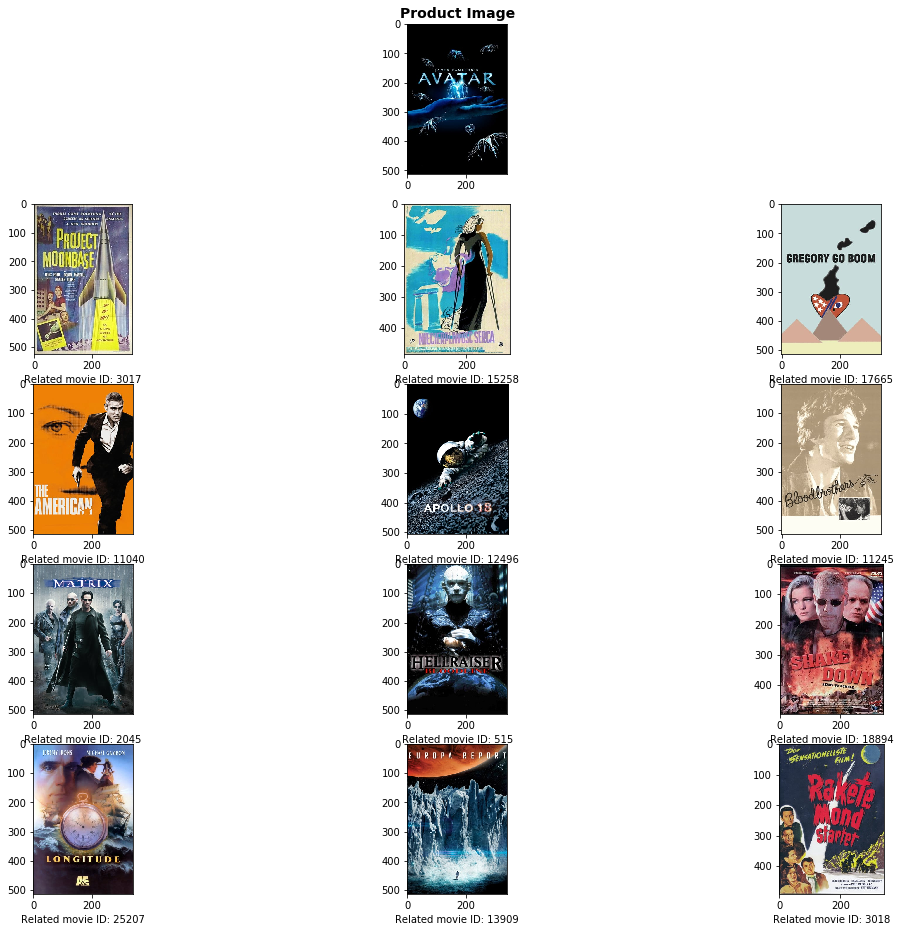

In [66]:
get_related_movies('tt0499549')

In [68]:
new_df['genres'].loc[[3017, 15258, 17665, 11040, 11245, 515, 18894, 25207, 13909, 3018]]

3017                     Science,Fiction
15258                      Drama,Romance
17665                             Comedy
11040               Crime,Drama,Thriller
11245                              Drama
515      Horror,Thriller,Science,Fiction
18894              Action,Drama,Thriller
25207             TV,Movie,Drama,History
13909           Science,Fiction,Thriller
3018                     Science,Fiction
Name: genres, dtype: object